**DICOM to NifTI converter** - didn't work well (had to rerun on Linux computer)

This scrips uses dcm2niix (https://github.com/rordenlab/dcm2niix/releases) converter

In [23]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import nibabel
import numpy as np

import mne
from mne.io.constants import FIFF
from mne.transforms import apply_trans

%matplotlib qt

import pandas as pd
import numpy as np

In [ ]:
import subprocess

dicom_dir = r"C:\Users\YourName\Documents\my_dicom"
output_dir = r"C:\Users\YourName\Documents\nifti_output"

subprocess.run(["dcm2niix", "-z", "y", "-o", output_dir, dicom_dir])

subprocess.run([
    r"C:\\Users\\a1902989\\Downloads\\dcm2niix_win\\dcm2niix.exe",
    "-z", "y",
    "-o", r"D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\DICOM",
    r"D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\DICOM\\NifTI"
])

CompletedProcess(args=['C:\\\\Users\\\\a1902989\\\\Downloads\\\\dcm2niix_win\\\\dcm2niix.exe', '-z', 'y', '-o', 'D:\\\\BonoKat\\\\research project\\\\# study 1\\\\mri_data\\\\Y\\\\DICOM', 'D:\\\\BonoKat\\\\research project\\\\# study 1\\\\mri_data\\\\Y\\\\DICOM\\\\NifTI'], returncode=5)

In [8]:
import subprocess
import os

# Full path to dcm2niix.exe
dcm2niix_path = r"C:\\Users\\a1902989\\Downloads\\dcm2niix_win\\dcm2niix.exe"

# Input and output directories
dicom_dir = r"D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\DICOM\\s1_pac_sub01"
output_dir = r"D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\NifTI\\s1_pac_sub01_test"

# Make sure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Run the command
result = subprocess.run([
    dcm2niix_path,
    "-z", "y",              # compress output
    "-o", output_dir,       # output folder
    dicom_dir               # input DICOM folder
], capture_output=True, text=True)

# Print output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)


STDOUT:
 Compression will be faster with C:\Users\a1902989\Downloads\dcm2niix_win\pigz.exe in the same folder as the executable
Chris Rorden's dcm2niiX version v1.0.20241211  (JP2:OpenJPEG) (JP-LS:CharLS) MSC1942  (64-bit Windows)
Found 192 DICOM file(s)
Convert 192 DICOM as D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\NifTI\\s1_pac_sub01_test\s1_pac_sub01_t1_mprage_sag_p2_20240625163413_2001 (240x256x192x1)
Conversion required 2.323000 seconds.

STDERR:
 


In [ ]:
import subprocess
import os
from pathlib import Path

# Path to dcm2niix executable
dcm2niix_path = r"C:\\Users\\a1902989\\Downloads\\dcm2niix_win\\dcm2niix.exe"

# Root directory containing DICOM folders (e.g., s1_pac_sub1, s2_pac_sub2, etc.)
dicom_root = Path(r"D:\\BonoKat\\research project\\# study 1\\mri_data\\O\\DICOM")

# Where to store converted NIfTI files
nifti_root = Path(r"D:\\BonoKat\\research project\\# study 1\\mri_data\\O\\NifTI")

# Make sure output root exists
nifti_root.mkdir(parents=True, exist_ok=True)

# Loop through each DICOM folder
for dicom_folder in dicom_root.iterdir():
    if dicom_folder.is_dir():
        subject_name = dicom_folder.name
        output_folder = nifti_root / subject_name
        output_folder.mkdir(exist_ok=True)

        print(f"Converting {subject_name}...")

        # Run dcm2niix
        result = subprocess.run([
            dcm2niix_path,
            "-z", "y",
            "-o", str(output_folder),
            str(dicom_folder)
        ], capture_output=True, text=True)

        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)

        if result.returncode != 0:
            print(f"❌ Conversion failed for {subject_name}")
            continue


        # Rename output NIfTI file to match folder name
        for file in output_folder.glob("*.nii.gz*"):
            new_name = output_folder / f"{subject_name}{file.suffix}"
            file.rename(new_name)

print("✅ All DICOMs converted and renamed.")


_____________________________

Read fs files

In [2]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subject = "s1_pac_sub01"
t1_fname = os.path.join(subjects_dir, subject, "mri", "T1.mgz")
t1 = nibabel.load(t1_fname)
t1.orthoview()

<OrthoSlicer3D: D:/BonoKat/research project/# study 1/mri_data/Y/fs/s1_pac_sub01/mri/T1.mgz (256, 256, 256)>

Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [4]:
Brain = mne.viz.get_brain_class()
brain = Brain(
    "s1_pac_sub01", hemi="lh", surf="pial", subjects_dir=subjects_dir, size=(800, 600)
)
brain.add_annotation("aparc.a2009s", borders=False)

Using pyvistaqt 3d backend.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [9]:
data = np.asarray(t1.dataobj)
print(data.shape)

(256, 256, 256)


In [22]:
fname = os.path.join(subjects_dir, subject, "surf", "lh.white")
rr_mm, tris = mne.read_surface(fname)
print(f"rr_mm.shape == {rr_mm.shape}")
print(f"tris.shape == {tris.shape}")
print(f"rr_mm.max() = {rr_mm.max()}")  # just to show that we are in mm

rr_mm.shape == (134495, 3)
tris.shape == (268986, 3)
rr_mm.max() = 91.75487518310547


In [23]:
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(600, 600), bgcolor="w", scene=False
)
gray = (0.5, 0.5, 0.5)
renderer.mesh(*rr_mm.T, triangles=tris, color=gray)
view_kwargs = dict(elevation=90, azimuth=0)  # camera at +X with +Z up
mne.viz.set_3d_view(
    figure=renderer.figure, distance=350, focalpoint=(0.0, 0.0, 40.0), **view_kwargs
)
renderer.show()

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [25]:
Torig = t1.header.get_vox2ras_tkr()
rr_vox = apply_trans(np.linalg.inv(Torig), rr_mm)
fig = imshow_mri(data, t1, vox, {"Scanner RAS": xyz_ras}, "MRI slice")

# Based on how imshow_mri works, the "X" here is the last dim of the MRI vol,
# the "Y" is the middle dim, and the "Z" is the first dim, so now that our
# points are in the correct coordinate frame, we need to ask matplotlib to
# do a tricontour slice like:
fig.axes[0].tricontour(
    rr_vox[:, 2],
    rr_vox[:, 1],
    tris,
    rr_vox[:, 0],
    levels=[vox[0]],
    colors="r",
    linewidths=1.0,
    zorder=1,
)

In [27]:
renderer_kwargs = dict(bgcolor="w")
renderer = mne.viz.backends.renderer.create_3d_figure(
    size=(800, 400), scene=False, **renderer_kwargs
)
curvs = [
    (
        mne.surface.read_curvature(
            os.path.join(subjects_dir, subj, "surf", "rh.curv"), binary=True)
        > 0
    ).astype(float)
    for subj in ("sample", "fsaverage")
    for _ in range(2)
]
fnames = [
    subjects_dir / subj / "surf" / surf
    for subj in ("sample", "fsaverage")
    for surf in ("rh.white", "rh.sphere")
]
y_shifts = [-450, -150, 450, 150]
z_shifts = [-40, 0, -30, 0]
for name, y_shift, z_shift, curv in zip(fnames, y_shifts, z_shifts, curvs):
    this_rr, this_tri = mne.read_surface(name)
    this_rr += [0, y_shift, z_shift]
    renderer.mesh(
        *this_rr.T,
        triangles=this_tri,
        color=None,
        scalars=curv,
        colormap="copper_r",
        vmin=-0.2,
        vmax=1.2,
    )
zero = [0.0, 0.0, 0.0]
width = 50.0
y = np.sort(y_shifts)
y = (y[1:] + y[:-1]) / 2.0 - width / 2.0
renderer.quiver3d(zero, y, zero, zero, [1] * 3, zero, "k", width, "arrow")
view_kwargs["focalpoint"] = (0.0, 0.0, 0.0)
mne.viz.set_3d_view(figure=renderer.figure, distance=1050, **view_kwargs)
renderer.show()

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs\\sample\\surf\\rh.curv'

In [41]:
bem_path = 'D:/BonoKat/research project/# study 1/mri_data/Y/fs/s1_pac_sub01/bem/s1_pac_sub01-head.fif'
surfaces = mne.read_bem_surfaces(bem_path)

    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


In [43]:
import mne
from mne.datasets import fetch_fsaverage

# Try reading a cortical surface (e.g., lh.pial)
surf_path = f"{subjects_dir}/{subject}/surf/lh.pial"
coords, faces = mne.read_surface(surf_path)
print(f"✅ Surface loaded. Vertices: {len(coords)}, Faces: {len(faces)}")


✅ Surface loaded. Vertices: 134495, Faces: 268986


Traceback (most recent call last):
  File "d:\BonoKat\research project\motor_pac\venv\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
TypeError: OrthoSlicer3D._cleanup() takes 1 positional argument but 2 were given


In [33]:
# Test a cortical surface
coords, faces = mne.read_surface(f"{subjects_dir}/{subject}/surf/lh.pial")
print(f"✅ lh.pial loaded: {len(coords)} vertices, {len(faces)} faces")

✅ lh.pial loaded: 134495 vertices, 268986 faces


In [35]:
txt_file_path = 'C:\\Users\\a1902989\\Box\\BonoKat\\#PhD Adelaide\\# research project\\# study 1\\dig_data\\Y\\s1_pac_sub01.txt'
mne.gui.coregistration(subject=subject, subjects_dir=subjects_dir)


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
    Triangle neighbors and vertex normals...
Using low resolution head model in D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\outer_skin.surf
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
    Triangle neighbors and vertex normals...
Using low resolution head model in D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\outer_skin.surf
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
Estimating fiducials from fsaverage.
Placing MRI fiducials - LPA
Using outer_skin.surf for head surface.
Placing MRI fiducials - LPA


Loading C:\Users\a1902989\Box\BonoKat\#PhD Adelaide\# research project\# study 1\dig_data\Y\s1_pac_sub01.txt
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Placing MRI fiducials - NASION
Using outer_skin.surf for head surface.
Placing MRI fiducials - RPA
Using outer_skin.surf for head surface.
No head shape point is omitted, the total is 1.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.
Using outer_skin.surf for head surface.


_____________________

Reading electrode locations

In [110]:
dig_folder = 'D:\\BonoKat\\research project\\# study 1\\dig_data\\Y'
dig_file = os.path.join(dig_folder, "s1_pac_sub01_test.txt")

# Set the header line
column_names = ['Electrode Name', 'Electrode Type', 'Session Name', 'Loc. X', 'Loc. Y', 'Loc. Z', 'm0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']
cols_to_drop = ['m0n0', 'm0n1', 'm0n2', 'm1n0', 'm1n1', 'm1n2', 'm2n0', 'm2n1', 'm2n2']

# Load the data, skipping the header lines
dig_points_df = pd.read_csv(dig_file, names=column_names, sep='\t', comment='#').iloc[:-1]
dig_points_df.drop(columns=cols_to_drop, inplace=True) # Drop electrode orientaiton columns
dig_points_df['Electrode Type'] = dig_points_df['Electrode Type'].replace('Session 1', 'fiducial') # Set 'fiducial'as electrode type
dig_points_df = dig_points_df.drop(columns=['Session Name']) # Drop the 'Session Name' column
dig_points_df = dig_points_df.dropna() # Drop rows with any NaN values

dig_points_df

,Electrode Name,Electrode Type,Loc. X,Loc. Y,Loc. Z
0,PZ,EEG,9.0000,-82.7433,84.9290
1,AF7,EEG,-52.6085,64.5538,15.0691
2,F5,EEG,-64.1519,38.7953,34.8584
3,C5,EEG,-82.0651,-18.4729,42.4110
4,POZ,EEG,5.3253,-106.0596,53.6421
...,...,...,...,...,...
59,PO8,EEG,57.7311,-97.7802,3.4139
60,P2,EEG,40.5271,-76.4376,78.4701
64,LPA,fiducial,139.3335,55.8965,-170.3642
65,Nasion,fiducial,23.6860,41.4335,-158.2550


In [125]:
import mne
import numpy as np


# Convert mm to m
dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']] = dig_points_df[['Loc. X', 'Loc. Y', 'Loc. Z']].astype(float).values / 1000 

# EEG electrodes
eeg_df = dig_points_df[dig_points_df['Electrode Type'] == 'EEG']
eeg_pos = dict(zip(
    eeg_df['Electrode Name'],
    np.vstack([eeg_df['Loc. X'], eeg_df['Loc. Y'], eeg_df['Loc. Z']]).T
))

# Fiducials
fid_df = dig_points_df[dig_points_df['Electrode Type'] == 'fiducial']
fid_pos = {row['Electrode Name'].lower(): [row['Loc. X'], row['Loc. Y'], row['Loc. Z']]
           for _, row in fid_df.iterrows()}

# Lowercase the montage keys to match MNE style
montage_renamed = {
    k.strip().capitalize(): v for k, v in eeg_pos.items()
}
# Create montage
montage = mne.channels.make_dig_montage(
    ch_pos=eeg_pos,
    # nasion=fid_pos['nasion'],
    # lpa=fid_pos['lpa'],
    # rpa=fid_pos['rpa'],
    coord_frame='head'  # 'head' if Brainsight .txt file was used
)


In [67]:
fid_pos

{'lpa': [139.3335, 55.8965, -170.3642],
 'nasion': [23.686, 41.4335, -158.255],
 'rpa': [50.842, 161.0303, -161.0877]}

In [74]:
sub_name = 's1_pac_sub01'
epochs_file = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{sub_name}\\preproc\\analysis\\{sub_name}_MAIN_epochs_plan_baseline-epo.fif'
epochs = mne.read_epochs(epochs_file)

Reading D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Adding metadata with 15 columns
50 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [126]:
epochs.set_montage(montage, match_case=False)


<EpochsFIF | 50 events (all good), -0.5 – 0.5 s (baseline -0.5 – 0.5 s), ~11.7 MB, data loaded, with metadata,
 'target_on': 50>

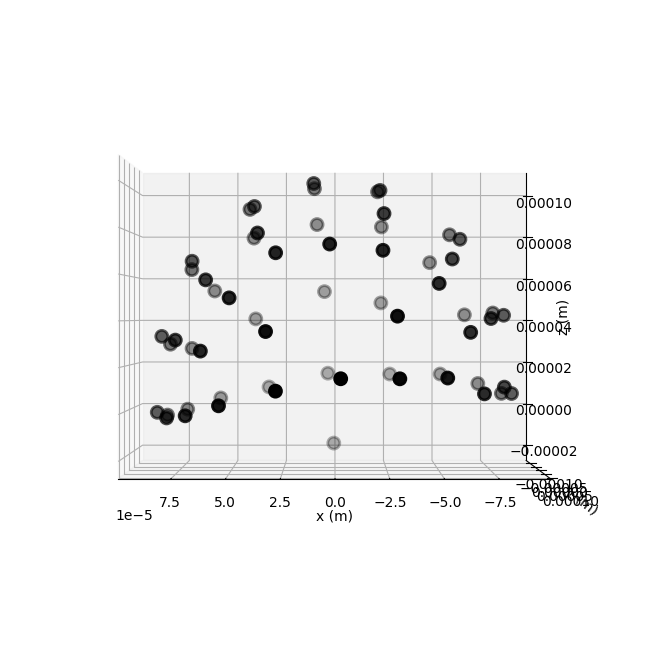

In [118]:
epochs.plot_sensors(kind='3d')

In [127]:
epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{sub_name}\\preproc\\analysis\\{sub_name}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


C:\Users\a1902989\AppData\Local\Temp\ipykernel_25912\2942655800.py:1: RuntimeWarning: This filename (D:\BonoKat\research project\# study 1\eeg_data\set\Y\s1_pac_sub01\preproc\analysis\s1_pac_sub01_MAIN_epochs_plan_baseline-epo_montage.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{sub_name}\\preproc\\analysis\\{sub_name}_MAIN_epochs_plan_baseline-epo_montage.fif', overwrite=True)


In [ ]:
mne.gui.coregistration()  # launches the same GUI from Python


In [ ]:
epochs.info['dig']  # Check the montage

In [ ]:
subjects_dir = 'D:\\BonoKat\\research project\\# study 1\\mri_data\\Y\\fs'
subject = "s1_pac_sub01"
info = f'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\{sub_name}\\preproc\\analysis\\{sub_name}_MAIN_epochs_plan_baseline-epo_montage.fif'
mne.gui.coregistration(subject=subject,
                       subjects_dir=subjects_dir,
                       inst=info)

# mne.gui.coregistration(subject=subject,
#                        subjects_dir=subjects_dir)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
    Triangle neighbors and vertex normals...
Using low resolution head model in D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\outer_skin.surf
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
    Triangle neighbors and vertex normals...
Using low resolution head model in D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\outer_skin.surf
    Triangle neighbors and vertex normals...
Using fiducials from: D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif.
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiduc

Saving D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif...
Overwriting existing file.
Loading MRI fiducials from D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif... Done!
Saving D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-fiducials.fif... Done!
Using outer_skin.surf for head surface.
Channel types::	eeg: 60
Aligning using fiducials
Start median distance:  68.18 mm
End   median distance:  13.59 mm
Fitting fiducials finished in 0.01 seconds.
Channel types::	eeg: 60


In [79]:
plot_kwargs = dict(
    subject=subject,
    subjects_dir=subjects_dir,
    surfaces="head-dense",
    dig=True,
    eeg=[],
    meg="sensors",
    show_axes=True,
    coord_frame="meg",
)

In [81]:
epochs.info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 60 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 63 items (3 Cardinal, 60 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 80.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: on
 sfreq: 500.0 Hz
>

In [84]:
print(subjects_dir)

D:\BonoKat\research project\# study 1\mri_data\Y\fs


In [131]:
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir, add_dist=False)


Setting up the source space with the following parameters:

SUBJECTS_DIR = D:\BonoKat\research project\# study 1\mri_data\Y\fs
Subject      = s1_pac_sub01
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\surf\lh.white...
Mapping lh s1_pac_sub01 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/134495 selected to source space (oct = 6)

Loading D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\surf\rh.white...
Mapping rh s1_pac_sub01 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\surf\rh.sphere...
Setting up the triangulation for the

In [134]:
bem = mne.make_bem_solution(mne.make_bem_model(subject, ico=4, conductivity=[0.3],
                                               subjects_dir=subjects_dir))
bem

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is   0.56 -26.75  37.77 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.


<ConductorModel | BEM (1 layer) solver=mne>

In [142]:
trans = 'D:\\BonoKat\\research project\\# study 1\\eeg_data\\set\\Y\\s1_pac_sub01\\preproc\\analysis\\s1_pac_sub01-trans'

In [143]:
fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src,
                                bem=bem, eeg=True, meg=False)
fwd

UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 193: character maps to <undefined>

In [130]:
from mne.coreg import Coregistration

fiducials = "estimated"  # get fiducials from fsaverage
coreg = Coregistration(epochs.info, subject, subjects_dir, fiducials=fid_pos)
fig = mne.viz.plot_alignment(epochs.info, trans=coreg.trans, **plot_kwargs)

    Triangle neighbors and vertex normals...
Using low resolution head model in D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\outer_skin.surf
    Triangle neighbors and vertex normals...
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


OSError: No head surface found for subject s1_pac_sub01 after trying:
D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\bem\s1_pac_sub01-head-dense.fif
D:\BonoKat\research project\# study 1\mri_data\Y\fs\s1_pac_sub01\surf\lh.seghead